### **CMPE 257 Assignment 5 - Amalgmation, HPO, AutoML and Classification**

**Objective function - Market segmentation** is important for small scale businesses to filter out their target markets. This can include segments of users whom they can target in order to increase sales, or segments of products that they can replace to increase their income.

**Dataset Number 1:** 
eCommerce customer behavior data

https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store




# **Data collection and preparation**

In [ ]:
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vT71NkW1z725FdPzaZ2wWumglSyeOh1PUUcHZ9t1s2zaUrc5gm7pRXmss9AXC-o7sirXrAK4Bd6kH6l/pub?gid=656397096&single=true&output=csv')
data = r.content
df_Oct = pd.read_csv(BytesIO(data), nrows=50000)
# df_Oct = df_Oct.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_Oct.shape

(50000, 8)

In [ ]:
df_Oct.head(3)

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2.294444e+18,2.273948e+18,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18


In [ ]:
##Importing the mall customer dataset
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vT0HMaqAgd7d_EyMRByWkVp8JM7jmp_969OPyfDMsk4pHpdWjPeQQePP0Rrfm4bwWxQVh7lJPPZHJvi/pub?gid=0&single=true&output=csv')
data = r.content
df_Mall = pd.read_csv(BytesIO(data))

In [ ]:
df_Mall.head(3)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


# **Required Data Preparation and Amalgamation**

In [ ]:
##Converting the date type to datetime type for 'event_time'
df_Oct['event_time'] = pd.to_datetime(df_Oct['event_time'], format='%Y-%m-%d %H:%M:%S UTC')

In [ ]:
##Splitting event_time into 2 columns containing date and time respectively
df_Oct['transaction_time'] = df_Oct['event_time'].dt.time
df_Oct['transaction_date'] = df_Oct['event_time'].dt.normalize()

In [ ]:
## We are calculating the total amount spent by each customer on electronice data.
df1 = df_Oct.groupby(['user_id']).agg({'price': 'sum'}).reset_index()

In [ ]:
df1.columns = ['user_id','total_spending']
df1.head(3)

,user_id,total_spending
0,1.515916e+18,624.98
1,1.515916e+18,43.96
2,1.515916e+18,856.23


In [ ]:
#Join the df_Oct df with the df1 df 
df_Oct = df_Oct.merge(df1,on='user_id')

In [ ]:
df_Oct.head(3)

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,transaction_time,transaction_date,total_spending
0,2020-04-24 11:50:39,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,11:50:39,2020-04-24,324.02
1,2020-04-24 11:50:39,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,11:50:39,2020-04-24,324.02
2,2020-04-24 14:37:43,2.294444e+18,2.273948e+18,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,14:37:43,2020-04-24,436.24


In [ ]:
##Calculating spending score to merge with mall customer dataset: Scaling down column 'total_spending'
df_Oct['Spending_Score'] = pd.qcut(df_Oct['total_spending'], q=100, labels=False)

In [ ]:
df_Mall = df_Mall.drop(columns=['CustomerID','Annual Income (k$)'])

In [ ]:
df_Mall.columns = ['Gender','Age','Spending_Score']
df_Mall.head(3)

,Gender,Age,Spending_Score
0,Male,19,39
1,Male,21,81
2,Female,20,6


In [ ]:
amalgamated_df = df_Oct.merge(df_Mall,on='Spending_Score')
amalgamated_df.head(3)

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,transaction_time,transaction_date,total_spending,Spending_Score,Gender,Age
0,2020-04-24 11:50:39,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,11:50:39,2020-04-24,324.02,57,Female,21
1,2020-04-24 11:50:39,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,11:50:39,2020-04-24,324.02,57,Female,50
2,2020-04-24 11:50:39,2.294360e+18,1.515966e+18,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,11:50:39,2020-04-24,324.02,57,Female,21


# **Customer lifetime value Calculation**
In marketing, customer lifetime value(CLV) is a prognostication of the net profit contributed to the whole future relationship with a customer. 
The purpose of the customer lifetime value metric is to assess the financial value of each customer. 

### **RFM**


1.   Recency - Latest date - Last order date. (Number of days since the last purchase date)
2.   Frequency - count of order ids. (Total number of transactions made by a unique customer)
3.   Monetary - Sum of Total sales. (Total value of transacted sales by each customer)

In [ ]:
from datetime import timedelta

#Latest date in the dataset + 1 to create latest date
latest_date = amalgamated_df['event_time'].max() + timedelta(1)

In [ ]:

RFM = amalgamated_df.groupby(amalgamated_df['user_id']).agg({'event_time': lambda x: (latest_date - x.max()).days, 
                                          'order_id': lambda x: len(x), 
                                          'price': lambda x: sum(x)})

In [ ]:
# RFMScores['event_time'] = RFMScores['event_time'].astype(int)
RFM.rename(columns={'event_time': 'Recency', 'order_id': 'Frequency', 'price': 'Monetary'}, inplace=True)

In [ ]:
RFM.head()

,Recency,Frequency,Monetary
user_id,,,
1.515916e+18,48,2.0,1249.96
1.515916e+18,53,1.0,43.96
1.515916e+18,49,3.0,2568.69
1.515916e+18,29,16.0,662.60
1.515916e+18,59,4.0,55.48


In [ ]:
RFM.describe()

,Recency,Frequency,Monetary
count,16998.000000,16998.000000,16998.000000
mean,116.088775,4.337334,756.793186
std,1220.891386,6.742133,1395.760905
min,1.000000,1.000000,6.660000
25%,14.000000,2.000000,64.790000
50%,38.000000,3.000000,208.280000
75%,55.000000,5.000000,1101.760000
max,18452.000000,252.000000,43760.650000


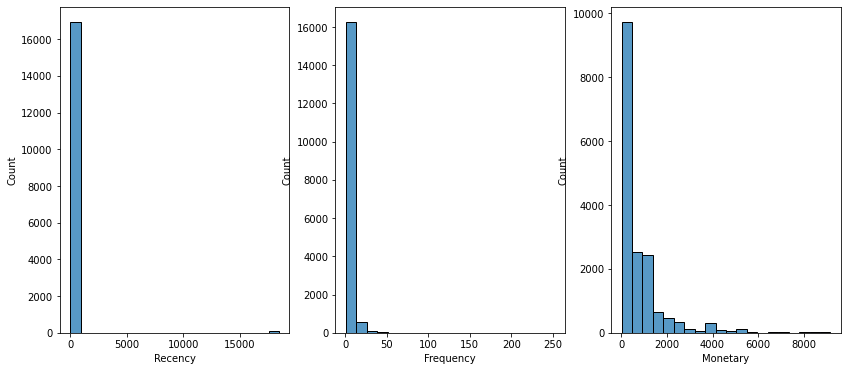

In [ ]:
# Distributions of Recency, Frequency, and Monetary features
# Here we will filter out the extreme values in the Frequency and Monetary columns to avoid the skewness the distribution
fig, ax = plt.subplots(1,3, figsize=(14,6))

sns.histplot(RFM.Recency, bins=20, ax=ax[0])
sns.histplot(RFM[RFM['Frequency']<1000]['Frequency'], bins=20, ax=ax[1])
sns.histplot(RFM[RFM['Monetary']<10000]['Monetary'], bins=20, ax=ax[2])
plt.show()


To conduct RFM analysis, we need to rank the customers based on the RFM scores.

Assume that we rank these customers from 1-4 using RFM values. (1-low score & 4-High score)

Steps to be followed for RFM ranking:

Sort the Recency column by most recent purchases at the top. For Frequency and Monetary features sort it by the most frequent and most valuable purchases at the top.
Here, we are using 4-scale ranking hence we need to divide the values into 4 groups.

In [ ]:
# Creating quantiles 
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles

{'Frequency': {0.25: 2.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 64.79, 0.5: 208.28, 0.75: 1101.76},
 'Recency': {0.25: 14.0, 0.5: 38.0, 0.75: 55.0}}

In [ ]:
# Creating RFM ranks
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''
    
    # checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
    
    # checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency','Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [ ]:
##Looping across the dataset and computing RFM values (1-4)
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [ ]:
RFM.head()

,Recency,Frequency,Monetary,R,F,M
user_id,,,,,,
1.515916e+18,48,2.0,1249.96,2,1,4
1.515916e+18,53,1.0,43.96,2,1,1
1.515916e+18,49,3.0,2568.69,2,2,4
1.515916e+18,29,16.0,662.60,3,4,3
1.515916e+18,59,4.0,55.48,1,3,1


We have calculated the ranks for each individual attribute of RFM at the customer level. We can use this to find the total number of rank groups that are created based on our ranking scale.

To do this you can simply combine all the individual R, F, and M ranks to check how many groups are created and the share of customers in each segment.

For our case, the maximum number of groups should be 4^3 = 64. Lets, check if it is true.

In [ ]:
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,Recency,Frequency,Monetary,R,F,M,Group
user_id,,,,,,,
1.515916e+18,48,2.0,1249.96,2,1,4,214
1.515916e+18,53,1.0,43.96,2,1,1,211
1.515916e+18,49,3.0,2568.69,2,2,4,224
1.515916e+18,29,16.0,662.60,3,4,3,343
1.515916e+18,59,4.0,55.48,1,3,1,131


In [ ]:
len(RFM['Group'].unique())

64

The reason for getting 48 instead of 64 rank groups is because there might be some missing combinations in the ranks of R, F, and M.

In [ ]:
##Calculate a composite score for these customers by combining their individual R, F, and M ranks to arrive at an aggregated RFM score.
RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,Recency,Frequency,Monetary,R,F,M,Group,Score
user_id,,,,,,,,
1.515916e+18,48,2.0,1249.96,2,1,4,214,7
1.515916e+18,53,1.0,43.96,2,1,1,211,4
1.515916e+18,49,3.0,2568.69,2,2,4,224,8
1.515916e+18,29,16.0,662.60,3,4,3,343,10
1.515916e+18,59,4.0,55.48,1,3,1,131,5


We can now use this score to assign Loyalty level to each customer instead of handling the N^3 rank groups. The Loyalty level will capture different behaviours of the customers and also helps in analyzing and targeting each customer group based on their behaviour.



In [ ]:
loyalty = ['AtRisk', 'NewCustomers', 'PotentialCustomers', 'LoyalCustomers']
RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels= loyalty)
RFM.head()

,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
user_id,,,,,,,,,
1.515916e+18,48,2.0,1249.96,2,1,4,214,7,NewCustomers
1.515916e+18,53,1.0,43.96,2,1,1,211,4,AtRisk
1.515916e+18,49,3.0,2568.69,2,2,4,224,8,PotentialCustomers
1.515916e+18,29,16.0,662.60,3,4,3,343,10,LoyalCustomers
1.515916e+18,59,4.0,55.48,1,3,1,131,5,AtRisk


In [ ]:
behaviour = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()
behaviour

,Recency,Frequency,Monetary,Score
Loyalty_Level,,,,
AtRisk,183.809543,1.596969,101.929339,4.202949
NewCustomers,92.359699,2.295878,334.511220,6.438795
PotentialCustomers,147.860063,5.055556,993.563158,8.466981
LoyalCustomers,19.918750,10.131818,1981.870310,10.732670


In [ ]:
RFM.shape

(16998, 9)

# **Classification 1: segmenting customers into 4 groups - using MLP**

In [ ]:
##Convert categorical to numeric
RFM['Loyalty_Level'].replace({
    'AtRisk': 0,
    'NewCustomers': 1,
    'PotentialCustomers': 2,
    'LoyalCustomers': 3
}, inplace = True)

In [ ]:
corr_matrix = RFM.corr()
corr_matrix['Loyalty_Level'].sort_values(ascending=False)

Loyalty_Level    1.000000
Score            0.964392
F                0.797391
M                0.748903
R                0.494989
Monetary         0.486306
Frequency        0.450264
Recency         -0.038728
Name: Loyalty_Level, dtype: float64

### **sklearn.neural_network.MLPClassifier**
This model optimizes the log-loss function using LBFGS or stochastic gradient descent.




In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
X = RFM.drop(['Loyalty_Level','Group','Score'],axis=1)
y = RFM['Loyalty_Level']

In [ ]:
X = RFM[['Recency','Frequency','Monetary']]
y = RFM[['Loyalty_Level']]
df_compare_1 = pd.DataFrame(columns=['alpha','max_iter', 'early_stopping','score'])

In [ ]:
from sklearn.preprocessing import StandardScaler
def mlpClassifier(custom_alpha, custom_max_iter, custom_early_stopping, X, y, df_compare_1):
  model = MLPClassifier(alpha=custom_alpha, max_iter=custom_max_iter, early_stopping=custom_early_stopping)
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
  model.fit(X_train, y_train)
  score = 100.0 * model.score(X_test, y_test)
  df_compare_1.loc[-1] = [custom_alpha, custom_max_iter, custom_early_stopping, score]  # adding a row
  df_compare_1.index = df_compare_1.index + 1  # shifting index
  df_compare_1 = df_compare_1.sort_index()
  df_compare_1.reset_index(drop=True)

In [ ]:
##With early stopping as True
mlpClassifier(1, 1000, True, X, y, df_compare_1)
mlpClassifier(2, 1000, True, X, y, df_compare_1)
mlpClassifier(3, 1000, True, X, y, df_compare_1)
mlpClassifier(4, 1000, True, X, y, df_compare_1)
mlpClassifier(1, 2000, True, X, y, df_compare_1)
mlpClassifier(1, 3000, True, X, y, df_compare_1)
mlpClassifier(1, 500, True, X, y, df_compare_1)
##With early stopping as False
mlpClassifier(1, 1000, False, X, y, df_compare_1)
mlpClassifier(2, 1000, False, X, y, df_compare_1)
mlpClassifier(3, 1000, False, X, y, df_compare_1)
mlpClassifier(4, 1000, False, X, y, df_compare_1)
mlpClassifier(1, 2000, False, X, y, df_compare_1)
mlpClassifier(1, 3000, False, X, y, df_compare_1)
mlpClassifier(1, 500, False, X, y, df_compare_1)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d

In [ ]:
df_compare_1

,alpha,max_iter,early_stopping,score
13,1,1000,True,62.794118
12,2,1000,True,61.970588
11,3,1000,True,62.088235
10,4,1000,True,57.323529
9,1,2000,True,62.058824
8,1,3000,True,61.823529
7,1,500,True,61.411765
6,1,1000,False,62.294118
5,2,1000,False,61.058824
4,3,1000,False,59.852941


### **References**
https://github.com/hariharan2305/Applied-Data-Science/blob/master/Marketing%20Analytics%20-%20RFM%20Modelling.ipynb
https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
